## **Intro**

This notebook provides high-dimensional infonet independence testing result.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
## path to the root directory
%cd /content/drive/MyDrive/InfoNet-main
print("Current working directory:", os.getcwd())

/content/drive/MyDrive/InfoNet-main
Current working directory: /content/drive/MyDrive/InfoNet-main


Import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
import torch
from model.decoder import Decoder
from model.encoder import Encoder
from model.infonet import infonet
from model.query import Query_Gen_transformer
from scipy.stats import rankdata
from scipy.special import digamma
from scipy.stats import gamma
from sklearn.metrics import roc_curve, auc

Generate samples from three different relationships.

In [4]:
def gen_gauss(N,d):

    mean = np.random.uniform(-5, 5, size=3*d)
    sigma = gen_cov(d)

    sample = np.random.multivariate_normal(mean, sigma, N)

    sigma_x = sigma[0:d, 0:d]
    sigma_y = sigma[d:2*d, d:2*d]
    sigma_z = sigma[2*d:3*d, 2*d:3*d]

    mi_xy = 0.5*np.log(np.linalg.det(sigma_x)*np.linalg.det(sigma_y)/np.linalg.det(sigma[0:2*d, 0:2*d]))
    mi_yz = 0.5*np.log(np.linalg.det(sigma_y)*np.linalg.det(sigma_z)/np.linalg.det(sigma[d:3*d, d:3*d]))

    return sample, mi_xy, mi_yz

def gen_independent(d, seq_len):
    mean = np.zeros(d)
    sigma = np.eye(d)
    X = np.random.multivariate_normal(mean, sigma, seq_len)
    Z = np.random.multivariate_normal(mean, sigma, seq_len)
    return X, Z

def gen_test1(d, seq_len):
    mean = np.zeros(d)
    sigma = np.eye(d)
    X = np.random.multivariate_normal(mean, sigma, seq_len)
    Z = np.random.multivariate_normal(mean, sigma, seq_len)
    tmp = np.dot(np.ones(d), X.T)
    #print(tmp.shape, np.ones(d).shape)
    Y = (np.outer(tmp, np.ones(d))/np.sqrt(d) + Z)/np.sqrt(2)
    return X, Y

def gen_test2(d, seq_len):
    mean = np.zeros(d)
    sigma = np.eye(d)
    X = np.random.multivariate_normal(mean, sigma, seq_len)
    Z = np.random.multivariate_normal(mean, sigma, seq_len)
    tmp1 = np.zeros(d//2)
    tmp2 = np.ones(d//2)
    Y = np.zeros((seq_len, d))
    for i in range(d):
        if i<=d//2:
            Y[:, i] = np.dot(np.concatenate((tmp2, tmp1)).T, X.T) + Z[:, i]
        else:
            Y[:, i] = np.dot(np.concatenate((tmp2, tmp1)).T, X.T) + Z[:, i]

    #print(tmp.shape, np.ones(d).shape)
    Y = Y/(d*np.sqrt(2))
    return X, Y

def gen_test3(d, seq_len):
    mean = np.zeros(d)
    sigma = np.eye(d)
    X = np.random.multivariate_normal(mean, sigma, seq_len)
    Z = np.random.multivariate_normal(mean, sigma, seq_len)
    Y = (X+Z)/np.sqrt(2)
    return X, Y

In [5]:
## infonet compute sliced mutual information
def infer(model, batch):
    model.eval()
    batch = torch.tensor(batch, dtype=torch.float32, device=device)
    with torch.no_grad():
        mi_lb = model(batch)
    return mi_lb

def compute_smi_mean(sample_x, sample_y, model, proj_num, seq_len, batchsize):
    ## we use sliced mutual information to estimate high dimensional correlation
    ## proj_num means the number of random projections you want to use, the larger the more accuracy but higher time cost
    ## seq_len means the number of samples used for the estimation
    ## batchsize means the number of one-dimensional pairs estimate at one time, this only influences the estimation speed
    dx = sample_x.shape[1]
    dy = sample_y.shape[1]
    results = []
    for i in range(proj_num//batchsize):
        batch = np.zeros((batchsize, seq_len, 2))
        for j in range(batchsize):
            theta = np.random.randn(dx)
            phi = np.random.randn(dy)
            x_proj = np.dot(sample_x, theta)
            y_proj = np.dot(sample_y, phi)
            x_proj = rankdata(x_proj)/seq_len
            y_proj = rankdata(y_proj)/seq_len
            xy = np.column_stack((x_proj, y_proj))
            batch[j, :, :] = xy
        infer1 = infer(model, batch).cpu().numpy()
        mean_infer1 = np.mean(infer1)
        results.append(mean_infer1)

    return np.mean(np.array(results))

Load checkpoint and do evaluation.

In [6]:
latent_dim = 256
latent_num = 256
input_dim = 2
decoder_query_dim = 1000
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim=input_dim,
    latent_num=latent_num,
    latent_dim=latent_dim,
    cross_attn_heads=8,
    self_attn_heads=16,
    num_self_attn_per_block=8,
    num_self_attn_blocks=1
)

decoder = Decoder(
    q_dim=decoder_query_dim,
    latent_dim=latent_dim,
)

query_gen = Query_Gen_transformer(
    input_dim = input_dim,
    dim = decoder_query_dim
)

model = infonet(encoder=encoder, decoder=decoder, query_gen = query_gen, decoder_query_dim = decoder_query_dim).to(device)
ckpt_path = os.path.join('saved', 'uniform', 'model_5000_32_1000-400--0.11.pt')
model.load_state_dict(torch.load(ckpt_path, map_location=device))

<All keys matched successfully>

In [7]:
def evaluate(model, seq_len, method, d, proj_num, num_test):

    smi_means = []
    y_labels = np.concatenate((np.ones(num_test//2), np.zeros(num_test//2)))

    for j in range(num_test//2):
        if method=='test1':
          X, Y = gen_test1(d, seq_len)
        elif method=='test2':
          X, Y = gen_test2(d, seq_len)
        elif method=='test3':
          X, Y = gen_test3(d, seq_len)
        smi_mean = compute_smi_mean(X, Y, model, proj_num, seq_len, batchsize=128)
        smi_means.append(smi_mean)

    for j in range(num_test//2):
        X, Y = gen_independent(d, seq_len)
        smi_mean = compute_smi_mean(X, Y, model, proj_num, seq_len, batchsize=128)
        smi_means.append(smi_mean)

    fpr_mean, tpr_mean, thresholds = roc_curve(y_labels, np.array(smi_means))

    roc_auc_mean = auc(fpr_mean, tpr_mean)

    return roc_auc_mean

/content/drive/MyDrive/InfoNet-main/model/gauss_mild.py:36: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(img, self.kernel, padding=padding, stride=1, groups=c_i)


=======================seq len 50 finished! mean auc is 0.9608
=======================seq len 100 finished! mean auc is 1.0
=======================seq len 150 finished! mean auc is 1.0
=======================seq len 200 finished! mean auc is 1.0
=======================seq len 250 finished! mean auc is 1.0
=======================seq len 300 finished! mean auc is 1.0
=======================seq len 50 finished! mean auc is 0.5972
=======================seq len 100 finished! mean auc is 0.806
=======================seq len 150 finished! mean auc is 0.8695999999999999
=======================seq len 200 finished! mean auc is 0.9364
=======================seq len 250 finished! mean auc is 0.9632000000000001
=======================seq len 300 finished! mean auc is 0.9952


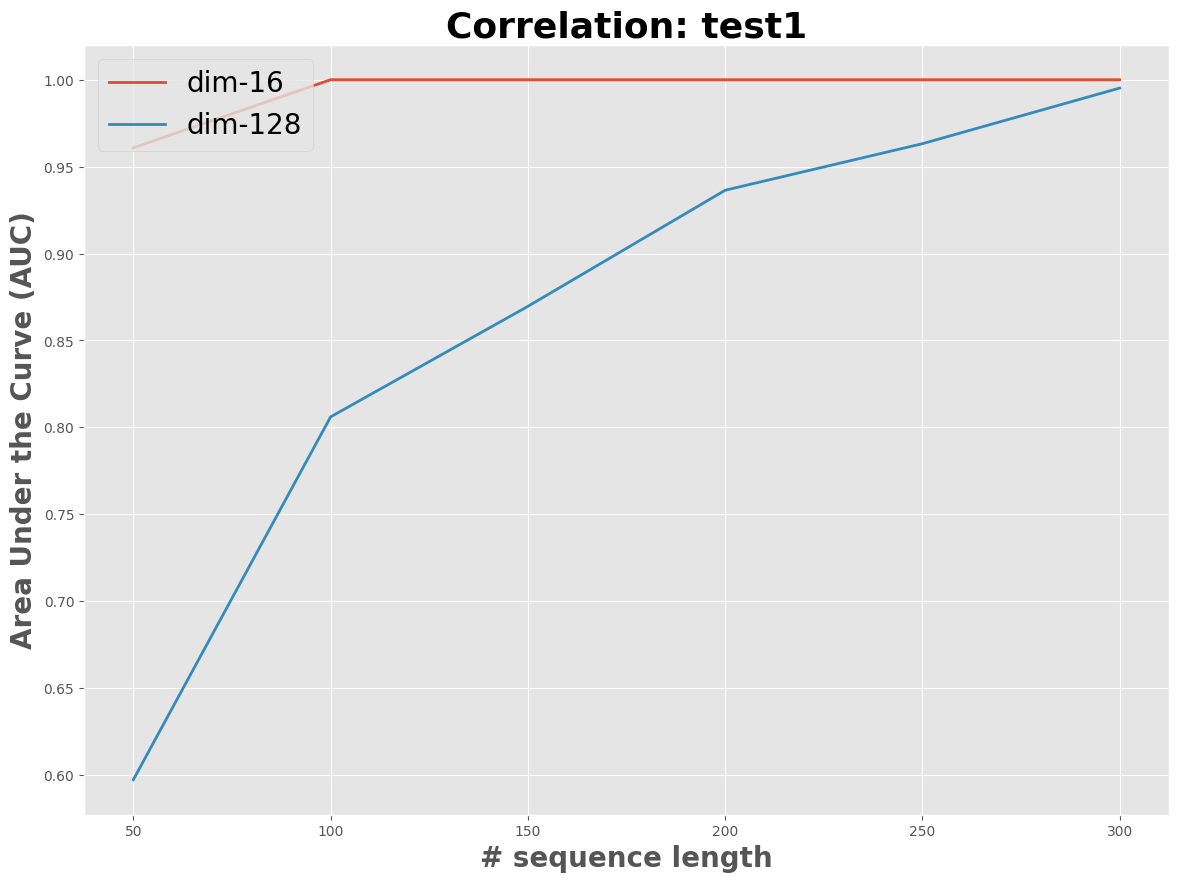

In [8]:
## relation ship 1
for method in ["test1"]:
  plt.style.use("ggplot")
  fig = plt.figure(figsize=(14, 10))
  ax1 = fig.add_subplot(111)
  for d in [16, 128]:
      auc_mean = []
      for seq_len in range(50, 350, 50):

          roc_auc_mean = evaluate(model, seq_len=seq_len, method=method, d=d, proj_num=1024, num_test=100)
          print(f"=======================seq len {seq_len} finished! mean auc is {roc_auc_mean}")
          auc_mean.append(roc_auc_mean)

      d_draw = range(50, 350, 50)
      ax1.plot(d_draw, auc_mean, lw=2, ls="-", label=f"dim-{d}", markersize=10)

  ax1.set_xlabel("# sequence length", fontweight="bold", fontsize=20)
  ax1.set_ylabel("Area Under the Curve (AUC)", fontweight="bold", fontsize=20)
  ax1.legend(fontsize=20, loc="upper left")
  ax1.set_title(f"Correlation: {method}", fontweight="bold", fontsize=26)

  plt.show()